<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Marco Antonio Sánchez Covarrubias. Cuauhtémoc Corrales Camacho

**Fecha:** 26 de Noviembre del 2021.

**Expediente** : if720268.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/MarcoSC08/Tarea10_MSanchez_CCorrales

# Tarea 10: Clase 24

## Enunciado de tarea 
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

**Código de solución estudiante 1**

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

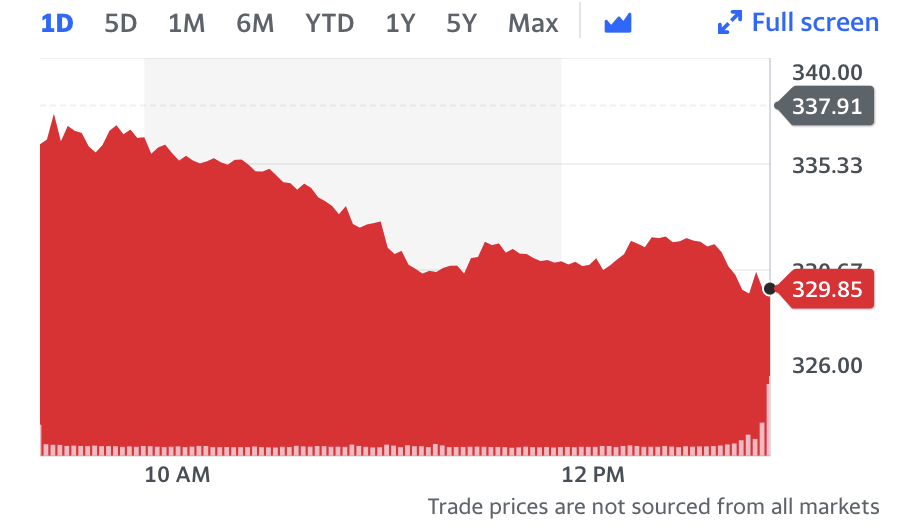

In [2]:
# Código de solución estudiante 1
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()


In [3]:
closes = get_adj_closes(['MSFT'], '2017-01-01')
closes_msft = closes.loc[:,'MSFT']
closes_msft

Date
2017-01-03     58.186
2017-01-04     57.925
2017-01-05     57.925
2017-01-06     58.427
2017-01-09     58.241
               ...   
2021-11-19    343.110
2021-11-22    339.830
2021-11-23    337.680
2021-11-24    337.910
2021-11-26    329.680
Name: MSFT, Length: 1235, dtype: float64

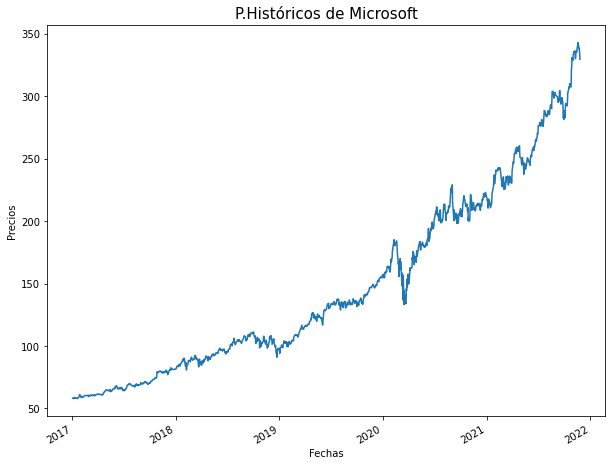

In [4]:
closes_msft.plot(figsize=(10,8));
plt.title('P.Históricos de Microsoft', fontsize=15)
plt.xlabel('Fechas')
plt.ylabel('Precios')
#plt.grid
plt.legend;

In [5]:
closes_msft[-1] #Ultimo precio

329.67999267578125

In [6]:
ret_msft = calc_daily_ret(closes_msft) #rendimientos

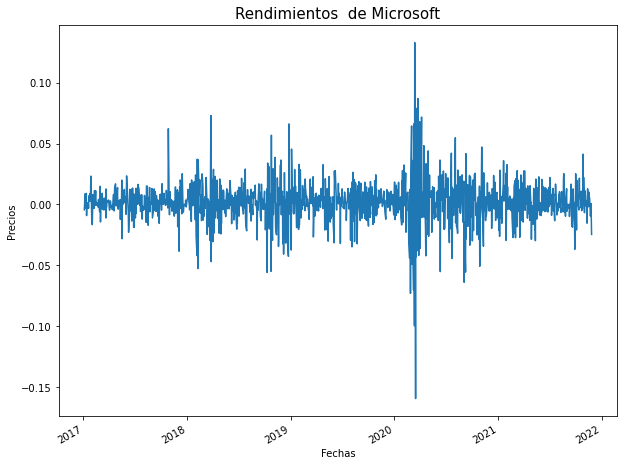

In [7]:
ret_msft.plot(figsize=(10,8));
plt.title('Rendimientos  de Microsoft', fontsize=15)
plt.xlabel('Fechas')
plt.ylabel('Precios')
#plt.grid
plt.legend;

In [8]:
mu = ret_msft.mean() #media
sigma = ret_msft.std() #desvest
r = 0.0021/360 #TLR
mu, sigma, r

(0.001405580174493474, 0.017335182544572694, 5.833333333333333e-06)

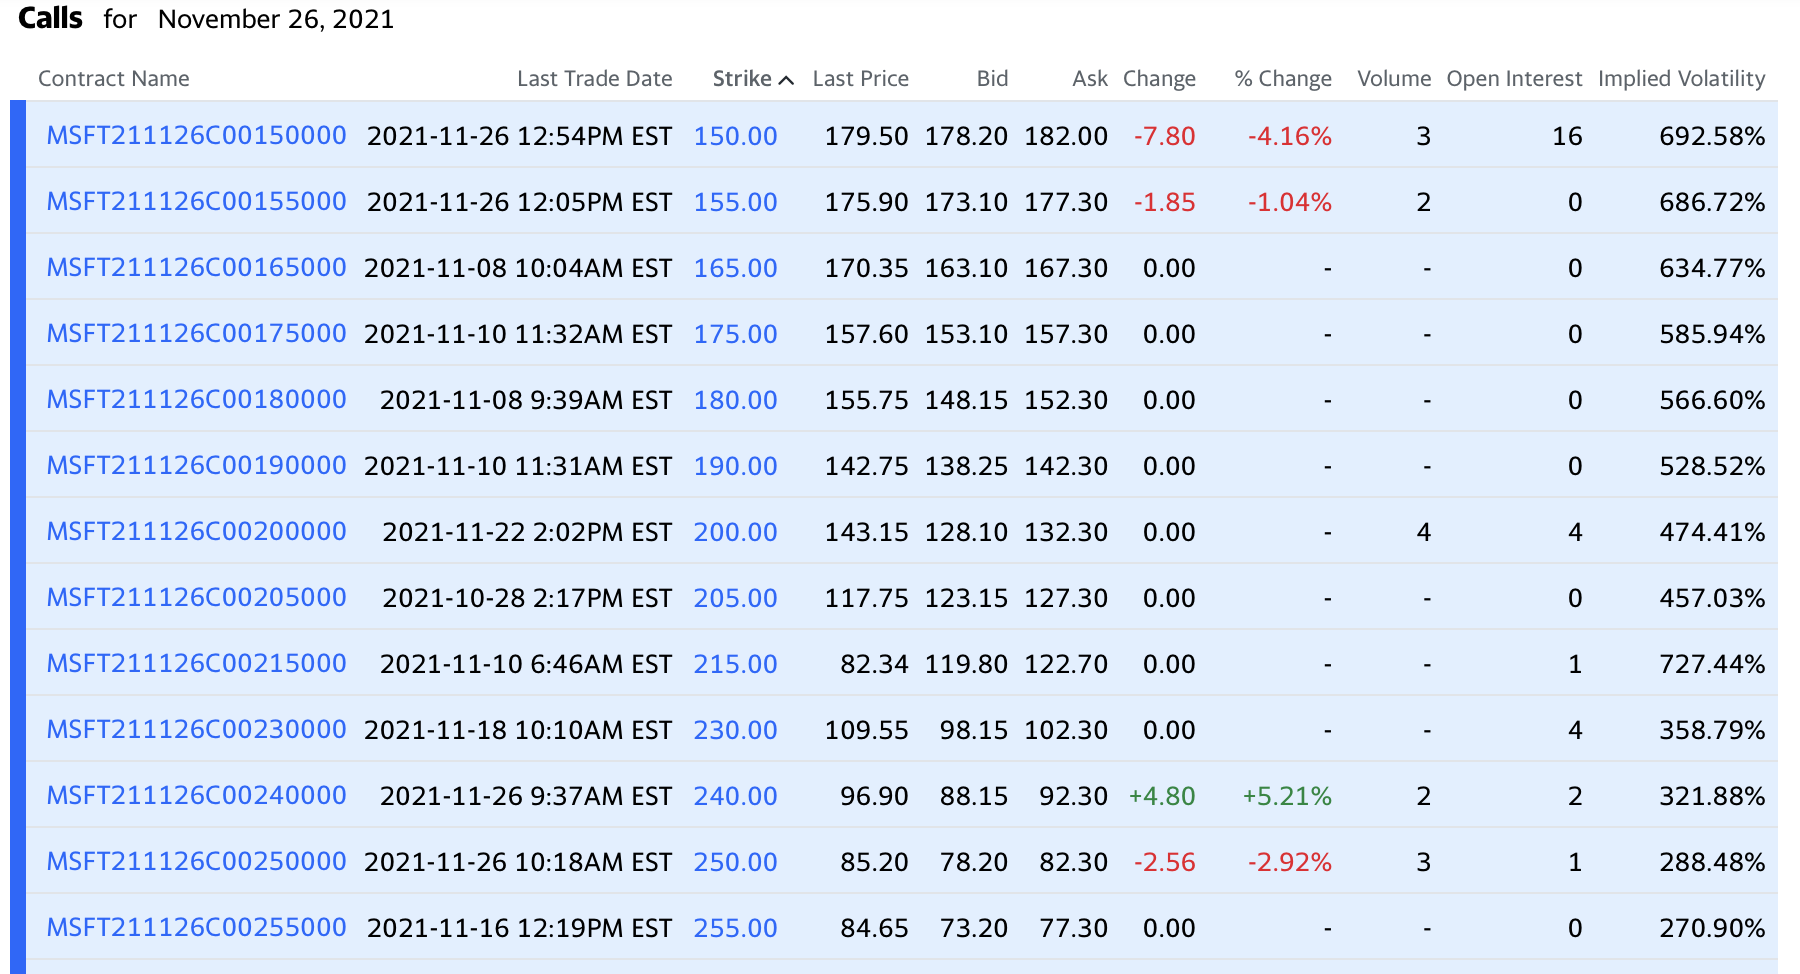

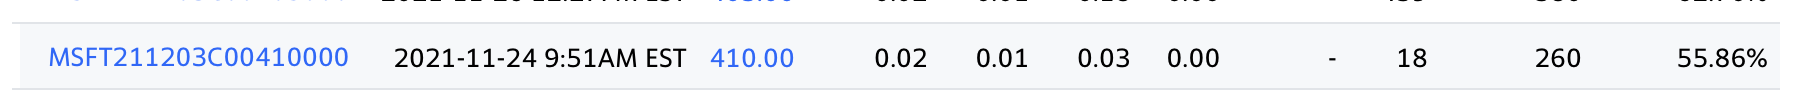

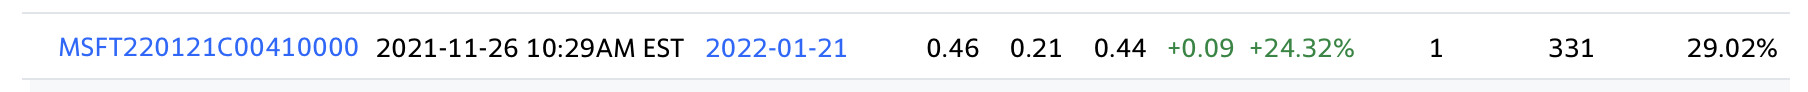

**Valuación con módelo normal de precios**

In [9]:
from datetime import date

In [10]:
ticker = 'MSFT'
source = 'stooq'
start = '2017-01-01'
end = datetime.today()
aapl_goo = web.DataReader(ticker, source, start=start)
aapl_goo.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-11-26,334.35,337.93,328.120,329.68,24217242
2021-11-24,336.28,338.16,333.911,337.91,21661307
2021-11-23,337.05,339.45,333.560,337.68,30427563
2021-11-22,344.62,349.67,339.550,339.83,31031113
2021-11-19,342.64,345.10,342.200,343.11,21963403


In [11]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [12]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = '2022-01-21'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

In [13]:
# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000


In [14]:
K = 410
S0 = closes_msft.iloc[-1]
K,S0

(410, 329.67999267578125)

In [15]:
ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[0,:]=S0

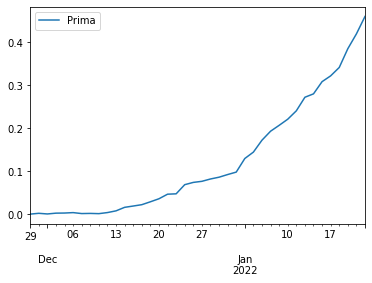

In [16]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [17]:
call_hist.iloc[-1]

Prima    0.46
Name: 2022-01-21 00:00:00, dtype: float64

### Opción barrera 'CALL'- down-and-out

In [18]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = 410
S0 = closes_msft.iloc[-1]

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
sim_closes.iloc[0,:] = S0

In [19]:
sim_closes

,0,1,2,...,9997,9998,9999
2021-11-29,329.680,329.680,329.680,...,329.680,329.680,329.680
2021-11-30,337.757,332.234,309.759,...,320.634,326.814,321.474
2021-12-01,339.476,334.954,311.534,...,316.769,330.152,320.123
2021-12-02,343.055,336.092,305.503,...,320.705,343.587,309.651
2021-12-03,336.309,345.036,310.806,...,329.599,334.830,316.116
...,...,...,...,...,...,...,...
2022-01-17,346.113,339.995,356.453,...,388.723,352.563,353.333
2022-01-18,337.735,336.567,369.055,...,388.366,355.219,354.047
2022-01-19,327.312,322.786,381.796,...,387.807,354.691,349.821
2022-01-20,326.707,322.564,372.931,...,391.873,345.997,357.130


In [20]:
pd.set_option('display.max_columns', 15)

# Precio barrera
B = 300

# Función de activación (knock-in)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes > B).cumprod(axis=0)  > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-11-29,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-11-30,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-12-01,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-12-02,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-12-03,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-17,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True
2022-01-18,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True
2022-01-19,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True
2022-01-20,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True


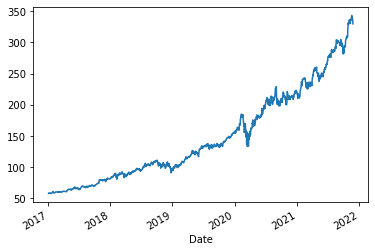

In [21]:
closes_msft.plot();

In [22]:
K = 410
S0 = S0
K, S0


(410, 329.67999267578125)

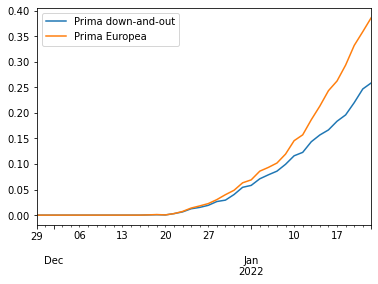

In [23]:
# Definir barrera
B = 328
# Crear función indicadora
I = (sim_closes > B).cumprod(axis=0)  > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

In [24]:
call.iloc[-1]

Prima Europea    0.387
Name: 2022-01-21 00:00:00, dtype: float64

Los resultados arrojados son de una prima menor, si el precio fluctuara entre los 330 la opción se desactiva, tomando como strike vigente para el próximo año $410.

### Put up and out

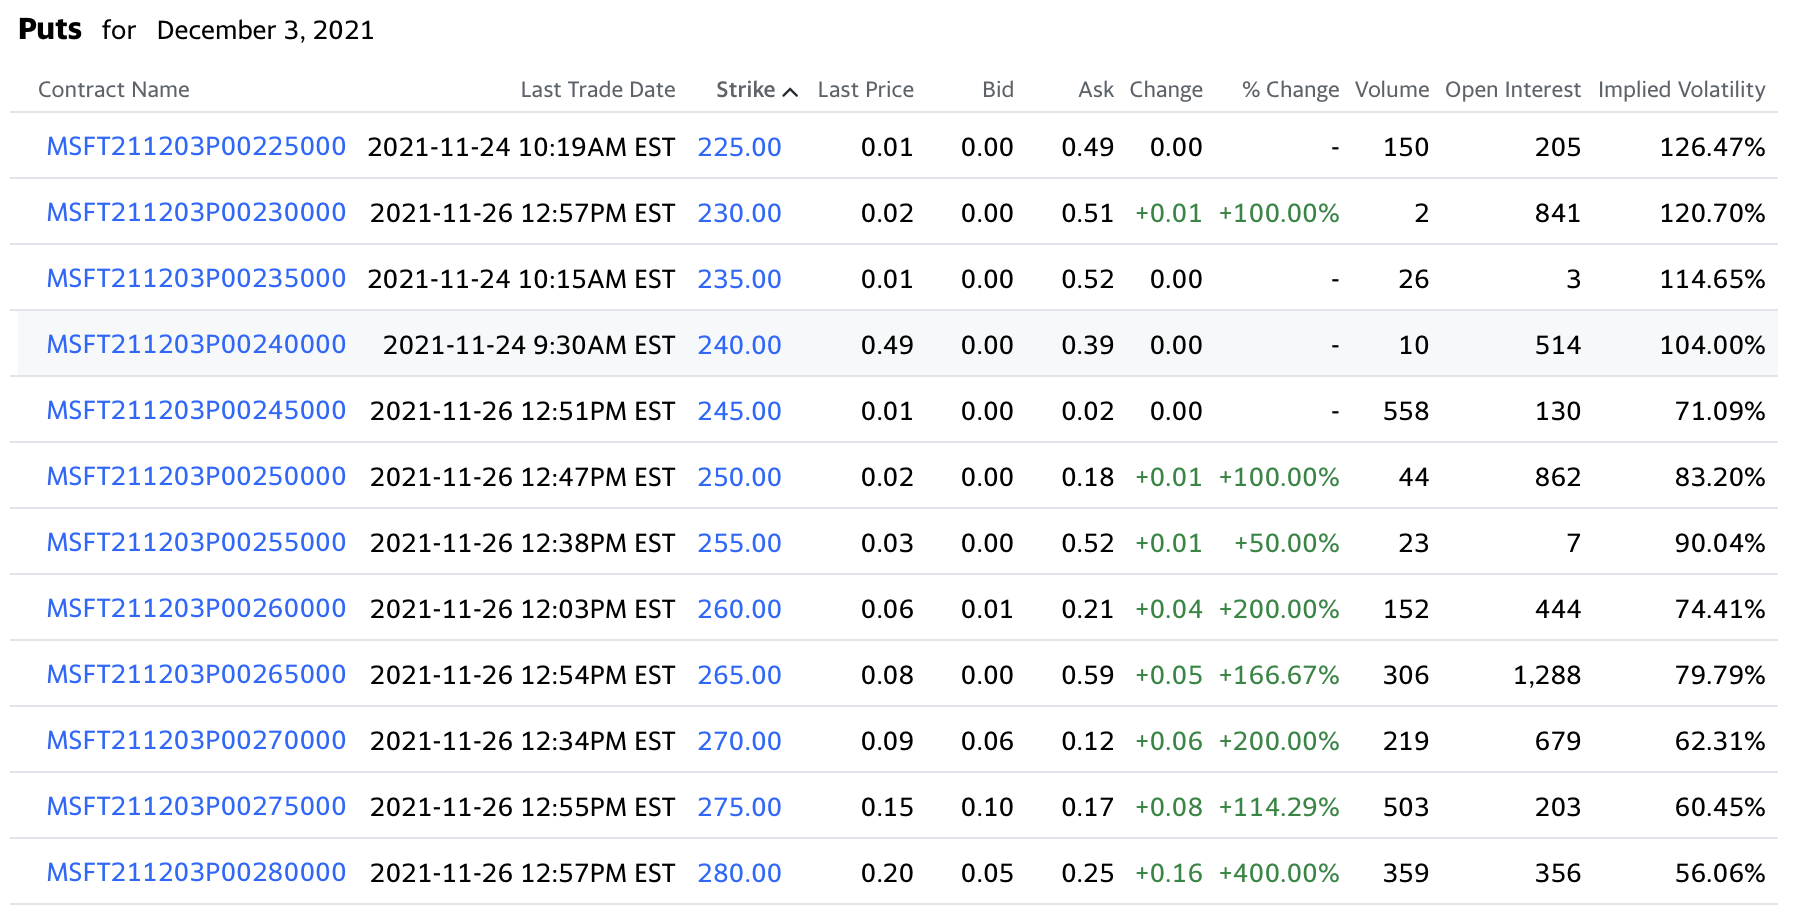

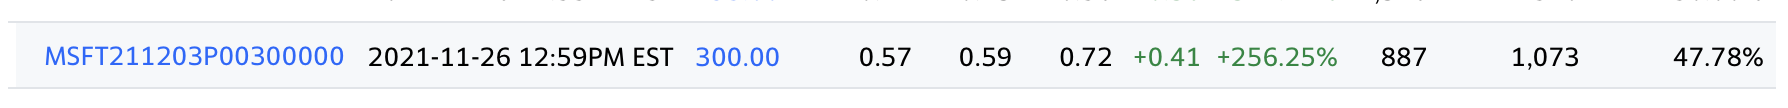

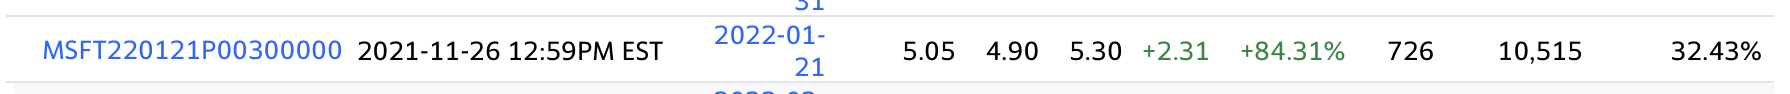

In [25]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = '2022-01-21'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = 300
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[0,:]=S0

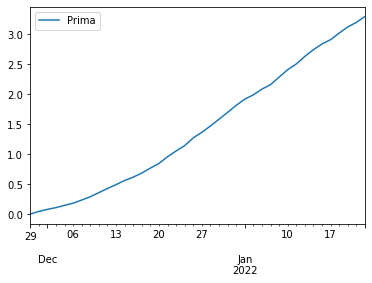

In [26]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [27]:
call_hist.iloc[-1]

Prima    3.292
Name: 2022-01-21 00:00:00, dtype: float64

In [28]:
pd.set_option('display.max_columns', 15)

# Precio barrera
B = 330

# Función  (Put  up and out )
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes < B).cumprod(axis=0)  > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-11-29,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-11-30,False,False,True,True,True,False,True,...,False,True,True,True,True,True,True
2021-12-01,False,False,True,True,False,False,True,...,False,True,True,True,True,False,True
2021-12-02,False,False,True,True,False,False,False,...,False,False,True,True,True,False,True
2021-12-03,False,False,True,True,False,False,False,...,False,False,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-17,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
2022-01-18,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
2022-01-19,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
2022-01-20,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False


In [29]:
K = 300
S0 = S0
K, S0

(300, 329.67999267578125)

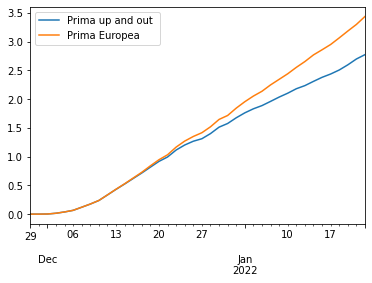

In [30]:
# Definir barrera
B = 340
# Crear función indicadora
I = (sim_closes < B).cumprod(axis=0)  > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike-sim_closes, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima up and out ':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

In [31]:
callui.iloc[-1]

Prima up and out     2.773
Name: 2022-01-21 00:00:00, dtype: float64

La prima arrojada es menor que la europea, dejando como barrera 340 y tomando como strike 300.

# Código de solución estudiante 2

## Activo Subyacente

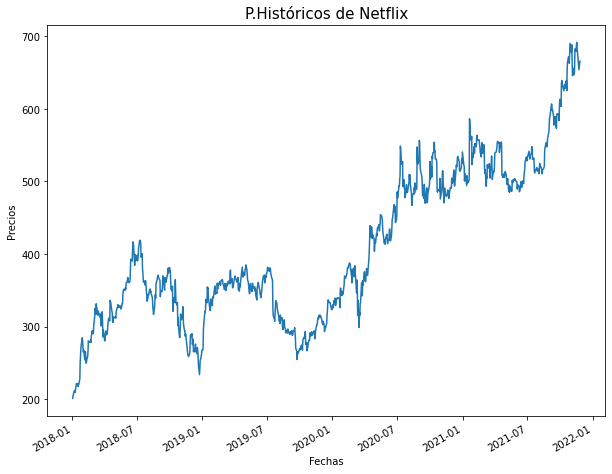

In [34]:
# Código de solución estudiante 2
closes = get_adj_closes(['NFLX'], '2018-01-01')
closes_nflx = closes.loc[:,'NFLX']
closes_nflx.plot(figsize=(10,8));
plt.title('P.Históricos de Netflix', fontsize=15)
plt.xlabel('Fechas')
plt.ylabel('Precios')
#plt.grid
plt.legend;

In [36]:
Last_close = closes_nflx[-1] #Ultimo precio
Last_close

665.6400146484375

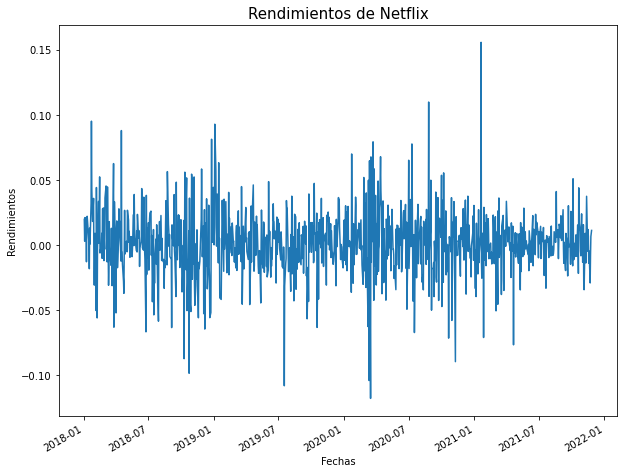

In [38]:
ret_nflx = calc_daily_ret(closes_nflx) #rendimientos
ret_nflx.plot(figsize=(10,8));
plt.title('Rendimientos de Netflix', fontsize=15)
plt.xlabel('Fechas')
plt.ylabel('Rendimientos')
#plt.grid
plt.legend;

In [40]:
# Metricas Del Activo
mu = ret_nflx.mean() #media
sigma = ret_nflx.std() #desvest
r = 0.0021/360 #TLR
mu, sigma, r

(0.0012177984367222018, 0.025471733022552782, 5.833333333333333e-06)

## Simulacion de Opcion CALL Europea

Para evaluar esta opcion, se eligio una opcion CALL de NEFLIX con un precio strike de 670 usd y tiene un precio establecido de 11.43 usd.

In [41]:
ticker = 'NFLX'
source = 'stooq'
start = '2018-01-01'
end = datetime.today()
aapl_goo = web.DataReader(ticker, source, start=start)
aapl_goo.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-11-26,675.00,676.405,660.67,665.64,2872513
2021-11-24,658.01,661.440,651.10,658.29,1867282
2021-11-23,658.18,666.430,646.05,654.06,2320917
2021-11-22,676.02,679.480,656.47,659.20,2765318
2021-11-19,692.35,694.160,675.00,678.80,2614852


In [42]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_nflx-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = '2022-01-21'
# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')
# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

In [45]:
# Comparacion precio strike y precio subyacente
K = 670
S0 = closes_nflx.iloc[-1]
K,S0

(670, 665.6400146484375)

In [46]:
ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[0,:]=S0

Prima    45.972
Name: 2022-01-21 00:00:00, dtype: float64

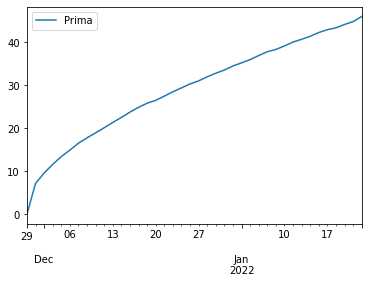

In [48]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();
call_hist.iloc[-1]

## Opción barrera 'CALL'- down-and-out

In [63]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = 670
S0 = closes_nflx.iloc[-1]

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
sim_closes.iloc[0,:] = S0

pd.set_option('display.max_columns', 15)

Prima Down and out     29.033
Name: 2022-01-21 00:00:00, dtype: float64

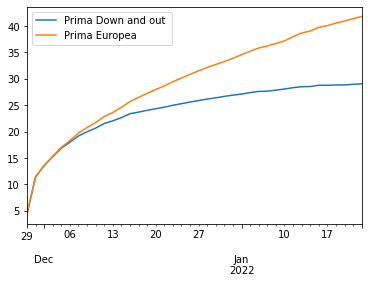

In [64]:
# Definir barrera
B = 700
# Crear función indicadora
I = (sim_closes < B).cumprod(axis=0)  > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike-sim_closes, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima Down and out ':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);
callui.iloc[-1]

**Conclusion**

Si se establece el precio de la barrera por encima del precio strike y del precio del activo subyacente, el precio de la prima se reduce. 

Prima Europea = **46** > Prima Up & Out = **27**

## Simulacion de Opcion PUT Europea

Para esta parte se tomara un opcion PUT con un precio strike de 660 usd con una prima de 9.66 usd.

In [56]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = '2022-01-21'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = 660
S0 = closes_nflx.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[0,:]=S0

Prima    36.4
Name: 2022-01-21 00:00:00, dtype: float64

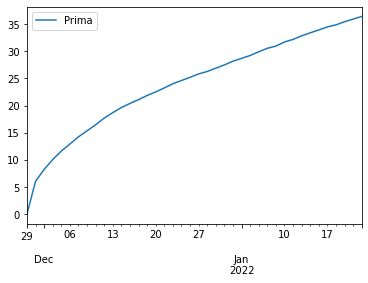

In [59]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_hist.plot();
put_hist.iloc[-1]

## Opcion Barrera Put up and out

In [60]:
K,S0

(660, 665.6400146484375)

Prima up and out     25.006
Name: 2022-01-21 00:00:00, dtype: float64

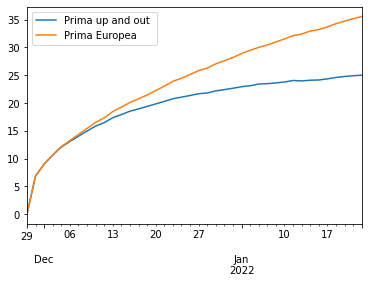

In [62]:
# Definir barrera
B = 700
# Crear función indicadora
I = (sim_closes < B).cumprod(axis=0)  > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike-sim_closes, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
putui = pd.DataFrame({'Prima up and out ':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui.plot();
put.plot(ax=ax);
putui.iloc[-1]

**Conclusiones** 

Si se coloca la opcion barrera en el mismo precio de 700, por encima del precio strike y del activo subyacente, se reduce el valor de la prima.

Prima Europea = **36** > Prima Up and Out = **25**